In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import torch
import torch.utils.data
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from PIL import Image
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
from torchvision import datasets,transforms
import torch.nn.functional as F
import cv2
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image
import numpy as np

In [0]:
!unzip chest-xray-pneumonia.zip

In [5]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] ="1,2"
imagefiles=[]
labels=[]
for folder in os.listdir('./chest_xray/train'):
    path=os.path.join('./chest_xray/train',folder)
    for images in os.listdir(path):
        imagefiles.append(os.path.join(path,images))
        labels.append(folder)
testimages=[]
testlabel=[]
for folder in os.listdir('./chest_xray/test'):
    path=os.path.join('./chest_xray/test',folder)
    for images in os.listdir(path):
        testimages.append(os.path.join(path,images))
        testlabel.append(folder)
enc={}
for i,label in enumerate(os.listdir('./chest_xray/train')):
    enc[label]=i

In [4]:
labels[:10]

['NORMAL',
 'NORMAL',
 'NORMAL',
 'NORMAL',
 'NORMAL',
 'NORMAL',
 'NORMAL',
 'NORMAL',
 'NORMAL',
 'NORMAL']

In [6]:
class Data(Dataset):
    def __init__(self,imagefiles,labels,testimages,testlabel,mode,enc=None,transform=None):
        self.imagefiles=imagefiles
        self.labels=labels
        self.testimages=testimages
        self.testlabel=testlabel
        self.mode=mode
        self.transform=transform
        self.enc=enc
    def __getitem__(self,idx):
        if self.mode=='train':
            image=Image.open(self.imagefiles[idx])
            image=np.asarray(image)
            image=torch.from_numpy(image)
            label=self.labels[idx]
            if self.transform:
                image=self.transform(image)
            return image,enc[label]
        if self.mode=='test':
            image=Image.open(self.testimages[idx])
            image=np.asarray(image)
            image=torch.from_numpy(image)
            label=self.testlabel[idx]
            if self.transform:
                image=self.transform(image)
            return image,enc[label]
    def __len__(self):
        if self.mode=='train':
            return len(self.imagefiles)
        if self.mode=='test':
            return len(self.testimages)

In [7]:
transform=transforms.Compose([
                              transforms.ToPILImage(),
                              transforms.Grayscale(num_output_channels=1),
                              transforms.Resize((100,100)),
                              transforms.RandomHorizontalFlip(p=0.5),
                              transforms.ToTensor(),
                              transforms.Normalize((0.5,),(0.5,))
])

In [8]:
mode1='train'
trainset=Data(imagefiles,labels,testimages,testlabel,mode1,enc,transform)

In [9]:
trainloader=torch.utils.data.DataLoader(trainset,batch_size=5,shuffle=True)

torch.Size([5])


torch.Size([5, 1, 100, 100])

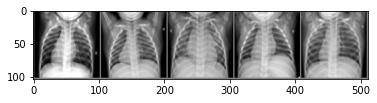

In [10]:
import torchvision
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
import matplotlib.pyplot as plt
img,lab=next(iter(trainloader))
x=torchvision.utils.make_grid(img)
imshow(x)
print(lab.shape)
img.shape

In [11]:
mode2='test'
testset=Data(imagefiles,labels,testimages,testlabel,mode2,enc,transform)
testloader=torch.utils.data.DataLoader(testset,batch_size=5,shuffle=False)

torch.Size([5])


torch.Size([5, 1, 100, 100])

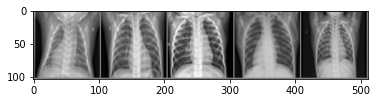

In [12]:
import torchvision
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
import matplotlib.pyplot as plt
img,lab=next(iter(testloader))
x=torchvision.utils.make_grid(img)
imshow(x)
print(lab.shape)
img.shape

In [13]:
class Encoder(nn.Module):
        ''' This the encoder part of VAE

        '''
        def __init__(self, input_dim, hidden_dim, z_dim):
            '''
            Args:
                input_dim: A integer indicating the size of input (in case of MNIST 28 * 28).
                hidden_dim: A integer indicating the size of hidden dimension.
                z_dim: A integer indicating the latent dimension.
            '''
            super().__init__()

            self.linear = nn.Linear(input_dim, hidden_dim)
            self.mu = nn.Linear(hidden_dim, z_dim)
            self.var = nn.Linear(hidden_dim, z_dim)

        def forward(self, x):
            # x is of shape [batch_size, input_dim]

            hidden = F.relu(self.linear(x))
            # hidden is of shape [batch_size, hidden_dim]
            z_mu = self.mu(hidden)
            # z_mu is of shape [batch_size, latent_dim]
            z_var = self.var(hidden)
            # z_var is of shape [batch_size, latent_dim]

            return z_mu, z_var

In [14]:
class Decoder(nn.Module):
        ''' This the decoder part of VAE

        '''
        def __init__(self, z_dim, hidden_dim, output_dim):
            '''
            Args:
                z_dim: A integer indicating the latent size.
                hidden_dim: A integer indicating the size of hidden dimension.
                output_dim: A integer indicating the output dimension (in case of MNIST it is 28 * 28)
            '''
            super().__init__()

            self.linear = nn.Linear(z_dim, hidden_dim)
            self.out = nn.Linear(hidden_dim, output_dim)

        def forward(self, x):
            # x is of shape [batch_size, latent_dim]

            hidden = F.relu(self.linear(x))
            # hidden is of shape [batch_size, hidden_dim]

            predicted = torch.sigmoid(self.out(hidden))
            # predicted is of shape [batch_size, output_dim]

            return predicted

In [15]:
class VAE(nn.Module):
        ''' This the VAE, which takes a encoder and decoder.

        '''
        def __init__(self, enc, dec):
            super().__init__()

            self.enc = enc
            self.dec = dec

        def forward(self, x):
            # encode
            z_mu, z_var = self.enc(x)

            # sample from the distribution having latent parameters z_mu, z_var
            # reparameterize
            std = torch.exp(z_var / 2)
            eps = torch.randn_like(std)
            x_sample = eps.mul(std).add_(z_mu)

            # decode
            predicted = self.dec(x_sample)
            return predicted, z_mu, z_var

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
encoder = Encoder(10000, 256, 20)

    # decoder
decoder = Decoder(20, 256, 10000)

    # vae
model = VAE(encoder, decoder)

    # optimizer
optimizer = optim.Adam(model.parameters(), lr=0.003)

In [17]:
best_test_loss = float('inf')
patience_counter=0
for epochs in range(0,50):
  train_loss=0
  test_loss = 0
  print('Started accessing trainloader')
  for img,lab in trainloader:
    img=img.view(-1,10000)
    img=F.softmax(img)
    #img=img.to(device)
    optimizer.zero_grad()
# forward pass
    img_sample, z_mu, z_var = model(img)
   # print(f'before softmax : {img_sample}')
    #img_sample=F.softmax(img_sample)
   # print(f'after softmax : {img_sample}')
    recon_loss = F.binary_cross_entropy(img_sample, img, size_average=False)
# kl divergence loss
    kl_loss = 0.5 * torch.sum(torch.exp(z_var) + z_mu**2 - 1.0 - z_var)
# total loss
    loss = recon_loss + kl_loss
    loss.backward()
    train_loss += loss.item()
    optimizer.step()
  else:
    with torch.no_grad():
      print('accessing test loader')
      for img,lab in testloader:
        # reshape the data
        img = img.view(-1, 10000)
        img=F.softmax(img)
       # img=img.to(device)
        # forward pass
        img_sample, z_mu, z_var = model(img)
        #img_sample=F.softmax(img_sample)
        # reconstruction loss
        recon_loss = F.binary_cross_entropy(img_sample, img, size_average=False)
        # kl divergence loss
        kl_loss = 0.5 * torch.sum(torch.exp(z_var) + z_mu**2 - 1.0 - z_var)
        # total loss
        loss = recon_loss + kl_loss
        test_loss += loss.item()
  torch.save(G.state_dict(), f"trained_generator_{j}th")
  train_loss /= len(trainloader)
  test_loss /= len(testloader)
  print(f'Epoch {epochs}, Train Loss: {train_loss:.2f}, Test Loss: {test_loss:.2f}')
  if best_test_loss > test_loss:
    best_test_loss = test_loss
    patience_counter = 1
  else:
    patience_counter += 1
  if patience_counter > 3:
    break

    


Started accessing trainloader


/tmp/ipykernel_11029/705284060.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  img=F.softmax(img)
/home/donghee/anaconda3/envs/sac/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


accessing test loader


/tmp/ipykernel_11029/705284060.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  img=F.softmax(img)


Epoch 0, Train Loss: 1035.86, Test Loss: 92.15
Started accessing trainloader
accessing test loader
Epoch 1, Train Loss: 81.51, Test Loss: 73.69
Started accessing trainloader
accessing test loader
Epoch 2, Train Loss: 72.67, Test Loss: 72.31
Started accessing trainloader
accessing test loader
Epoch 3, Train Loss: 67.10, Test Loss: 64.12
Started accessing trainloader
accessing test loader
Epoch 4, Train Loss: 62.20, Test Loss: 60.35
Started accessing trainloader
accessing test loader
Epoch 5, Train Loss: 59.60, Test Loss: 58.67
Started accessing trainloader
accessing test loader
Epoch 6, Train Loss: 57.61, Test Loss: 57.37
Started accessing trainloader
accessing test loader
Epoch 7, Train Loss: 55.83, Test Loss: 54.89
Started accessing trainloader
accessing test loader
Epoch 8, Train Loss: 54.19, Test Loss: 53.65
Started accessing trainloader
accessing test loader
Epoch 9, Train Loss: 53.29, Test Loss: 53.02
Started accessing trainloader
accessing test loader
Epoch 10, Train Loss: 52.95,

In [48]:
for i in range(30):
    z = torch.randn(1, 20)
    reconstructed_img = model.dec(z)
    img = reconstructed_img.view(1, 100, 100).data
    
    from torchvision.utils import save_image
    save_image(img, f"img_{i}.png")


torch.Size([1, 20])
torch.Size([1, 100, 100])
torch.Size([1, 100, 100])
torch.Size([1, 20])
torch.Size([1, 100, 100])
torch.Size([1, 100, 100])
torch.Size([1, 20])
torch.Size([1, 100, 100])
torch.Size([1, 100, 100])
torch.Size([1, 20])
torch.Size([1, 100, 100])
torch.Size([1, 100, 100])
torch.Size([1, 20])
torch.Size([1, 100, 100])
torch.Size([1, 100, 100])
torch.Size([1, 20])
torch.Size([1, 100, 100])
torch.Size([1, 100, 100])
torch.Size([1, 20])
torch.Size([1, 100, 100])
torch.Size([1, 100, 100])
torch.Size([1, 20])
torch.Size([1, 100, 100])
torch.Size([1, 100, 100])
torch.Size([1, 20])
torch.Size([1, 100, 100])
torch.Size([1, 100, 100])
torch.Size([1, 20])
torch.Size([1, 100, 100])
torch.Size([1, 100, 100])
torch.Size([1, 20])
torch.Size([1, 100, 100])
torch.Size([1, 100, 100])
torch.Size([1, 20])
torch.Size([1, 100, 100])
torch.Size([1, 100, 100])
torch.Size([1, 20])
torch.Size([1, 100, 100])
torch.Size([1, 100, 100])
torch.Size([1, 20])
torch.Size([1, 100, 100])
torch.Size([1, 100